# RFM Segmentation of an e-commerce customers

## Readme



#### *Data dictionary:*

![alt text](https://drive.google.com/uc?id=1uHctVrDklymIhK9_i4kCAERYki8CJJa1)



---


#### *Goal*

1. The goal of this analysis is to segment customers using the RFM model in order to identify different purchasing behaviours
2. Provide actionable business strategies.



---


#### *Index*
  - Library
  - 0. Upload dataset
  - 1. Data preprocessing
  - 2. Clustering
  - 3. RFM Segmentation
  - 4. Conclusion
  - Export data

## Library

In [56]:
!pip install df2tables

In [57]:
# Library

## Basic
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbn
import datetime as dt
from collections import Counter

## Scipy
from scipy import stats
from scipy.spatial.distance import cdist

## Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Table
from df2tables import render_nb,render

## Global setting
SEED=30
palette=sbn.color_palette("hls", 5)
plt.rcParams["font.family"] = "monospace"

## 0. Upload dataset

In [58]:
## Dataset
### Upload dataset
data=pd.read_csv("https://raw.githubusercontent.com/VincenzoPaternoster/Project_PAI/refs/heads/main/E-commere_Project/Edited%20data/fact_sales.txt")

In [59]:
## Show dataset
data

,order_id,customer_id,date_id,channel_id,status_id,product_id,product_name,category_id,quantity,price,amount
0,10001,191,121,1,3,132,product 132,5,5,90.90,454.50
1,10001,191,121,1,3,120,product 120,4,4,52.31,209.24
2,10001,191,121,1,3,120,product 120,4,2,52.31,104.62
3,10001,191,121,1,3,92,product 92,1,4,53.00,212.00
4,10002,50,318,3,2,20,product 20,6,4,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
9571,11909,86,134,1,3,150,product 150,5,3,91.94,275.82
9572,11049,137,265,3,3,189,product 189,3,1,111.36,111.36
9573,12357,96,74,3,3,68,product 68,6,2,55.56,111.12
9574,12915,105,363,3,2,47,product 47,4,4,101.73,406.92


In [60]:
# Count how many orders were cancelled
Counter(data["status_id"]) #### 1117 orders

Counter({3: 8008, 2: 1117, 1: 451})

In [61]:
# Delete cancelled orders
data=data[data["status_id"]!=2] #### 2 is ID of cancelled orders

In [62]:
data # from 9576 rows to 8459 rows

,order_id,customer_id,date_id,channel_id,status_id,product_id,product_name,category_id,quantity,price,amount
0,10001,191,121,1,3,132,product 132,5,5,90.90,454.50
1,10001,191,121,1,3,120,product 120,4,4,52.31,209.24
2,10001,191,121,1,3,120,product 120,4,2,52.31,104.62
3,10001,191,121,1,3,92,product 92,1,4,53.00,212.00
7,10003,106,297,1,3,162,product 162,6,3,80.20,240.60
...,...,...,...,...,...,...,...,...,...,...,...
9570,12159,277,297,3,3,6,product 6,6,1,51.33,51.33
9571,11909,86,134,1,3,150,product 150,5,3,91.94,275.82
9572,11049,137,265,3,3,189,product 189,3,1,111.36,111.36
9573,12357,96,74,3,3,68,product 68,6,2,55.56,111.12


In [63]:
## Get the original date through date_id

## Upload date dateaset
date_data=pd.read_csv("https://raw.githubusercontent.com/VincenzoPaternoster/Project_PAI/refs/heads/main/E-commere_Project/Edited%20data/dim_date.txt")

In [64]:
## Date Dataset
date_data

,date_id,date_og,nb_year,quarter_id,nb_month,nm_month,nb_day,nm_day,nb_week,season
0,1,2024-01-07,2024,2024-Q1,1,January,7,Sunday,2,winter
1,2,2024-12-04,2024,2024-Q4,12,December,4,Wednesday,49,winter
2,3,2024-12-27,2024,2024-Q4,12,December,27,Friday,52,winter
3,4,2024-01-30,2024,2024-Q1,1,January,30,Tuesday,5,winter
4,5,2024-05-03,2024,2024-Q2,5,May,3,Friday,18,spring
...,...,...,...,...,...,...,...,...,...,...
360,361,2024-12-20,2024,2024-Q4,12,December,20,Friday,51,winter
361,362,2024-09-11,2024,2024-Q3,9,September,11,Wednesday,37,autumn
362,363,2024-01-06,2024,2024-Q1,1,January,6,Saturday,1,winter
363,364,2024-06-03,2024,2024-Q2,6,June,3,Monday,23,summer


## 1. Data preprocessing

### 1.1 Merge dataset

In [65]:
# Get the original date through merge procedure

merge_data=data.merge(date_data[["date_id","date_og"]],how="left",on="date_id")

## Convert column date_og in datetime
merge_data["date_og"]=pd.to_datetime(merge_data["date_og"])

## Create variable to make difference between date
diff_date=max(merge_data["date_og"])

In [66]:
merge_data

,order_id,customer_id,date_id,channel_id,status_id,product_id,product_name,category_id,quantity,price,amount,date_og
0,10001,191,121,1,3,132,product 132,5,5,90.90,454.50,2024-05-21
1,10001,191,121,1,3,120,product 120,4,4,52.31,209.24,2024-05-21
2,10001,191,121,1,3,120,product 120,4,2,52.31,104.62,2024-05-21
3,10001,191,121,1,3,92,product 92,1,4,53.00,212.00,2024-05-21
4,10003,106,297,1,3,162,product 162,6,3,80.20,240.60,2024-07-27
...,...,...,...,...,...,...,...,...,...,...,...,...
8454,12159,277,297,3,3,6,product 6,6,1,51.33,51.33,2024-07-27
8455,11909,86,134,1,3,150,product 150,5,3,91.94,275.82,2024-07-23
8456,11049,137,265,3,3,189,product 189,3,1,111.36,111.36,2024-02-20
8457,12357,96,74,3,3,68,product 68,6,2,55.56,111.12,2024-07-28


In [67]:
## Create subset by Customer_id with aggregations of count order_id,sum of amount and days from the last purchase

df=merge_data.groupby(by="customer_id").agg(frequency_order=("order_id","count"),
                                                        recency_day=("date_og", lambda x: (diff_date-max(x)).days),
                                                        monetary_amount=("amount","sum")).reset_index()

In [68]:
df

,customer_id,frequency_order,recency_day,monetary_amount
0,1,10,4,1649.21
1,2,19,17,5893.28
2,3,25,52,4645.74
3,4,35,151,6827.34
4,5,16,30,3342.64
...,...,...,...,...
345,346,11,77,2175.17
346,347,73,10,16115.55
347,348,20,84,4212.10
348,349,36,35,9786.69


In [69]:
## Chech for wrong values

## Frequency
print(df[df["frequency_order"]<=0])

## Recency
print(df[df["recency_day"]<0])

## Monetary
print(df[df["monetary_amount"]<=0])

Empty DataFrame
Columns: [customer_id, frequency_order, recency_day, monetary_amount]
Index: []
Empty DataFrame
Columns: [customer_id, frequency_order, recency_day, monetary_amount]
Index: []
Empty DataFrame
Columns: [customer_id, frequency_order, recency_day, monetary_amount]
Index: []


In [70]:
# Are there null values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      350 non-null    int64  
 1   frequency_order  350 non-null    int64  
 2   recency_day      350 non-null    int64  
 3   monetary_amount  350 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 11.1 KB


### 1.2 Test skeweness

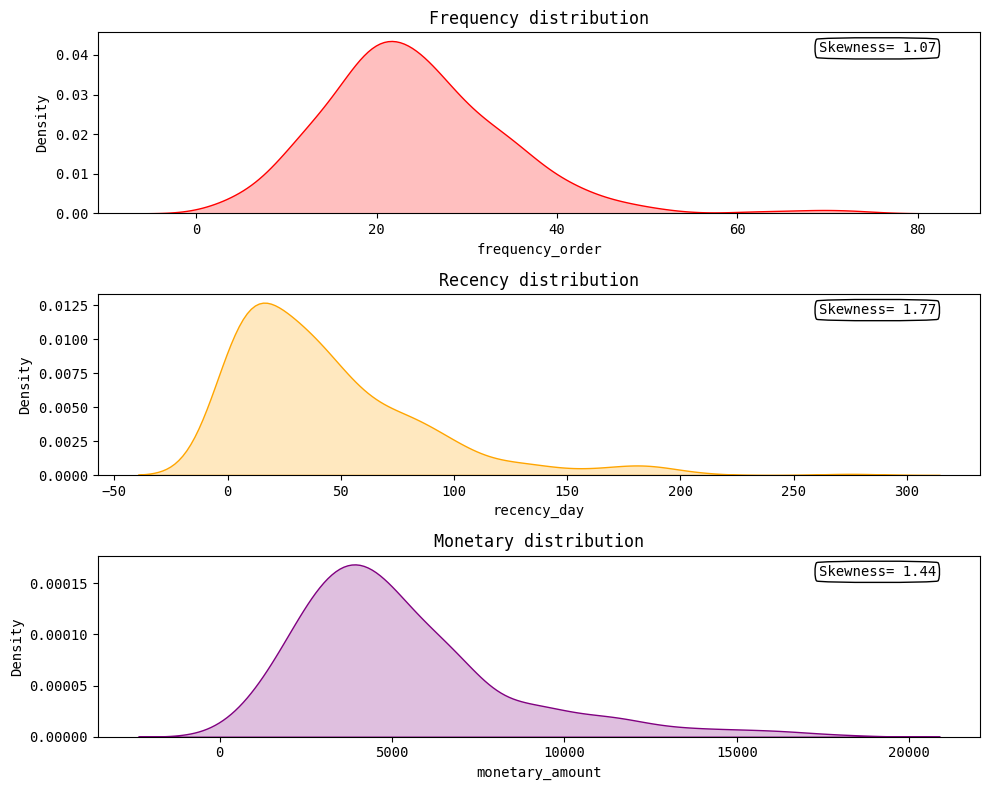

In [71]:
# Test skewness

## Set dimension of charts
fig, axs = plt.subplots(3,1, figsize=(10,8))

## First chart: Frequency distribution
sbn.kdeplot(df["frequency_order"], fill=True, ax=axs[0],color="red")
axs[0].set_title("Frequency distribution")
axs[0].text(x=0.95, y=0.95, s=f"Skewness= {df['frequency_order'].skew().round(2)}", transform=axs[0].transAxes, ha='right', va='top',bbox=dict(boxstyle="round4",fc="w"))

## Second chart: Recency distributiom
sbn.kdeplot(df["recency_day"], fill=True, ax=axs[1],color="orange")
axs[1].set_title("Recency distribution")
axs[1].text(x=0.95, y=0.95, s=f"Skewness= {df['recency_day'].skew().round(2)}", transform=axs[1].transAxes, ha='right', va='top',bbox=dict(boxstyle="round4",fc="w"))

## Third chart: Monetary distribution
sbn.kdeplot(df["monetary_amount"], fill=True, ax=axs[2],color="purple")
axs[2].set_title("Monetary distribution")
axs[2].text(x=0.95, y=0.95, s=f"Skewness= {df['monetary_amount'].skew().round(2)}", transform=axs[2].transAxes, ha='right', va='top',bbox=dict(boxstyle="round4",fc="w"))

plt.tight_layout()
plt.show()

#### **Note on skewness**

The density plots show that all distributions are skewed to the right (positive skewness):

* The recency and monetary variables show a strong right skew, with long tails on the right indicating the presence of customers with unusually high recency or spending values.

* The frequency variable shows moderate right skewness.

Since the recency graph shows negative values when I checked, there were no negative values, so it is possible that kdeplot may be affecting the graph.

Furthermore, all density plots show extreme values, so we now identify them to understand whether they are outliers or extreme values.

### 1.3 Check for outliers

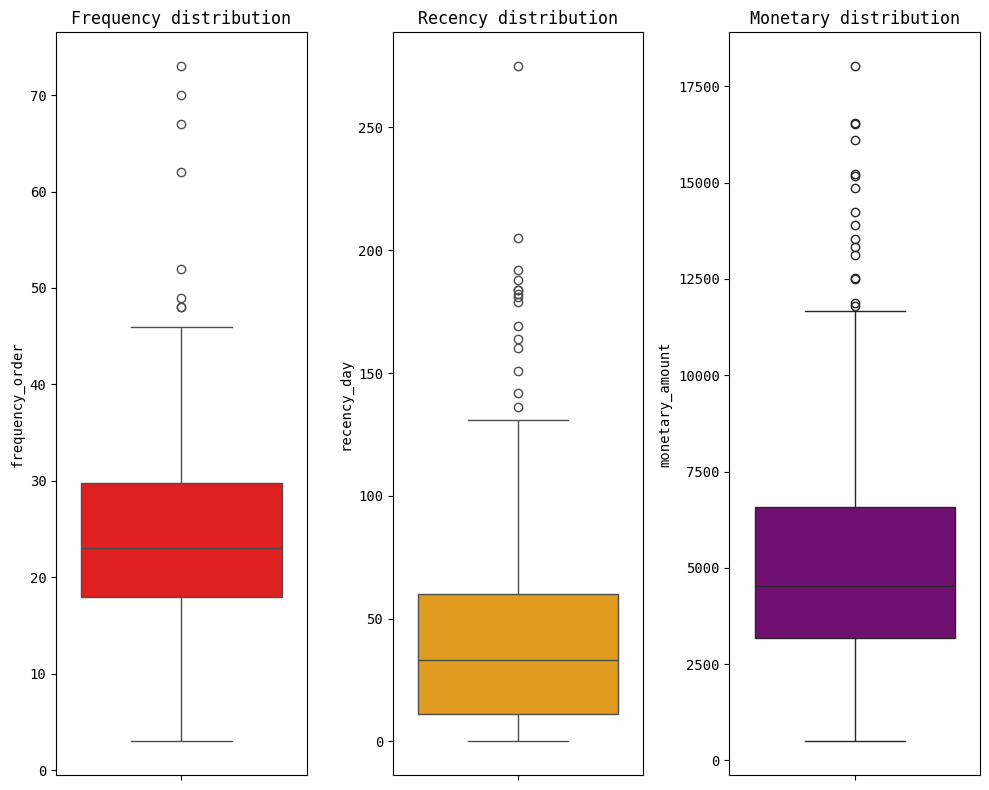

In [72]:
## Are there outliers?

## Frequency
fig,axs=plt.subplots(1,3,figsize=(10,8))
sbn.boxplot(data=df["frequency_order"],ax=axs[0],color="red")
axs[0].set_title("Frequency distribution")

## Recency
sbn.boxplot(data=df["recency_day"],ax=axs[1],color="orange")
axs[1].set_title("Recency distribution") ## The recency boxplot starts at 0, so previously kedplot presented a biased recency distribution.

## Monetary
sbn.boxplot(data=df["monetary_amount"],ax=axs[2],color="purple")
axs[2].set_title("Monetary distribution")

plt.tight_layout()
plt.show()

In [73]:
## Identify outliers
print(np.quantile(df["frequency_order"],0.5))
print(np.quantile(df["monetary_amount"],0.5))
print(np.quantile(df["recency_day"],0.5))
df[(df["frequency_order"]>np.quantile(df["frequency_order"],0.95)) & (df["monetary_amount"]>np.quantile(df["monetary_amount"],0.95))]



23.0
4537.74
33.0


,customer_id,frequency_order,recency_day,monetary_amount
95,96,43,131,16541.00
97,98,70,23,13902.09
120,121,42,38,18027.02
129,130,67,33,13531.99
183,184,49,43,11609.40
193,194,45,18,16519.31
307,308,44,28,12520.24
346,347,73,10,16115.55


#### **Note on extreme values**

There are several extreme values, but none of them appear to be outliers (in this context, outliers will be used as errors or anomalies).

 Furthermore, the main objective is to apply df segmentation to customers, so removing these extreme values could result in a loss of information (for example, with df segmentation we try to find patterns of behaviour among customers, so it is important to take into account all the variability of customers).

 For this reason, the next step will be to try to understand whether there are differences between clustering with raw data and clustering with scaled data to which transformation techniques have been applied, in order to understand whether extreme values can influence the data.


## 2. Clustering

### 2.1 Clustering with raw data

#### 2.1.1 How many clusters do we need?

In [74]:
### Define function to choose number of clusters to use

def how_many_clusters(X,title=False):

    # Get intertias and silhouettes
    inertias = []
    silhouettes = []
    clust_diff={}

    for k in range(2, 12):
        kmeans = KMeans(n_clusters=k, random_state=SEED).fit(X)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(X, kmeans.labels_))
        clust_diff[k] = sum(np.min(cdist(X, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]


    # Elbow method
    plt.plot(range(2, 12), inertias, marker='^')
    plt.xlabel("k")
    plt.ylabel("Inertia")

    if title:

      plt.title("Elbow Method with raw data")

    else:
      plt.title("Elbow Method with scaled/transformed data")

    plt.show()

    # SSE score
    print("\nINERTIA (SSE) VALUES:")
    for numb, val in clust_diff.items():
      print(f"{numb} : {val}")
    print("\n")

    # Silhouette score
    plt.plot(range(2, 12), silhouettes, marker='o', color='green')
    plt.xlabel("k")
    plt.ylabel("Score")

    if title:

      plt.title("Silhouette Score with raw data")

    else:
      plt.title("Silhouette Score with scaled/transformed data")
    plt.show()

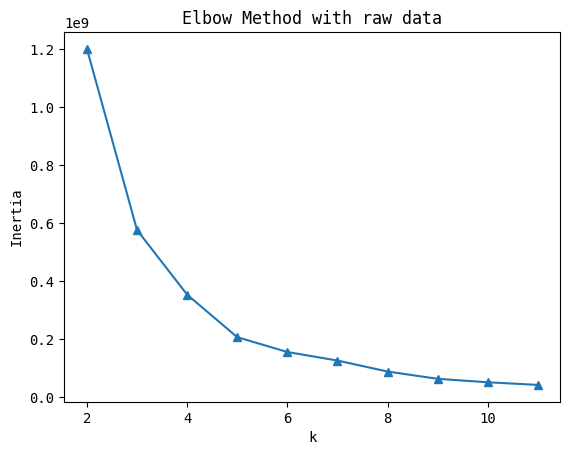


INERTIA (SSE) VALUES:
2 : 1435.433607630763
3 : 1031.2113265764199
4 : 854.5066635526639
5 : 622.0130465951703
6 : 522.323196387189
7 : 451.36156699184585
8 : 422.69243396952714
9 : 352.5950963735633
10 : 308.88237745948794
11 : 279.0468077896818




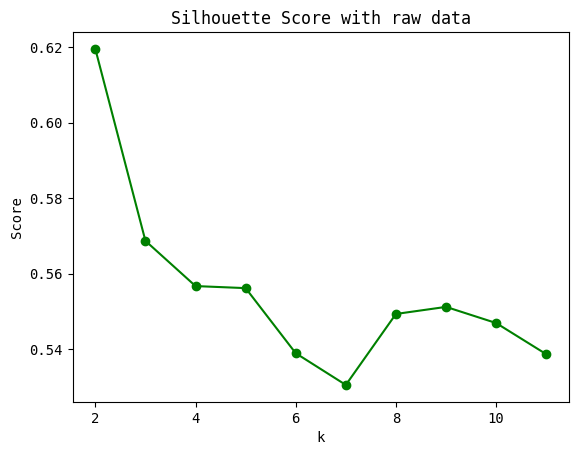

In [75]:
## Raw data clusters
how_many_clusters(df[["frequency_order","recency_day","monetary_amount"]],title=True)

#### **Note on the number of clusters**

Looking at the elbow method graphs and SSE values, we should use 6 clusters, but in the silhouette graph, the 6 clusters show a decrease in the silhouette score compared to the 5 clusters. So now I will try to visualise both solutions and then decide which one to use.

#### 2.1.2 Show clusters

In [76]:
# View clusters of model

# Function for view clusters

def view_clust(X,k,title=False):

    # X features
    # k number of clusters

    # KMeans
    kmeans=KMeans(n_clusters=k,init="k-means++",random_state=SEED).fit(X)
    centers=kmeans.cluster_centers_
    y_kmeans=kmeans.predict(X)

    # View clusters

    # 2 FEATURES
    if X.shape[1]==2:

      # Set labels of axes
      plt.xlabel(X.columns[0])
      plt.ylabel(X.columns[1])

      # Plot scatter
      sbn.scatterplot(x=X[X.columns[0]],y=X[X.columns[1]],hue=pd.Categorical(y_kmeans),s=100)
      plt.scatter(centers[:,0],centers[:,1],c="black",s=200,alpha=0.8,marker="*")

      # Write SSD value on chart
      plt.text(1.2,0,f"SSD: {kmeans.inertia_:.2f}",ha='right', va='bottom', transform=plt.gca().transAxes)

      # Set title of chart
      if title:

        plt.title(f"Scatterplot of {X.columns[0]} and {X.columns[1]} with raw data")

      else:

        plt.title(f"Scatterplot of {X.columns[0]} and {X.columns[1]} with scaled/transformed data")

      plt.legend(title="Cluster")
      plt.show()

    # 3 FEATURES
    elif X.shape[1] == 3:

        fig = plt.figure(figsize=(18, 8))

        views = [(30, 45),(10, -60)]  # 3D Views: I decided to use three graphs for the same data because
                                       #           I noticed that only some clusters were visible, so I decided
                                       #           to plot two graphs with two different perspectives to
                                       #           improve the interpretation. ,

        # Get limits for each axes
        xmin, xmax = X[X.columns[0]].min(), X[X.columns[0]].max()
        ymin, ymax = X[X.columns[1]].min(), X[X.columns[1]].max()
        zmin, zmax = X[X.columns[2]].min(), X[X.columns[2]].max()

        # Use a loop to plot two different views of the same graph

        for i, (elev, azim) in enumerate(views, start=1): ## elev= moves the angle from the Y to the Z
                                                          ## azim= moves the angle from the X to the Y

            ax = fig.add_subplot(1, len(views), i, projection='3d') ## Set 1 row, and lenght of views columns and the number of charts
                                                           ## to display two charts side by side

            ax.view_init(elev=elev, azim=azim) # set elevation and azim in degrees instead of radians
                                               # makes it easier to move the angle
            # Set name of axes
            ax.set_xlabel(X.columns[0])
            ax.set_ylabel(X.columns[1])
            ax.set_zlabel(X.columns[2])

            # Assign labels for each cluster
            for cluster in np.unique(y_kmeans): ## For each unique cluster of y_kmeans

                labs = y_kmeans == cluster ## create boolean mask to understand which observations belong to the current cluster

                ax.scatter3D(X.loc[labs, X.columns[0]], # to filter for each column or feature the observations associated to each cluster
                             X.loc[labs, X.columns[1]],
                             X.loc[labs, X.columns[2]],
                             label=f"Cluster {cluster}", s=60, alpha=0.7)

            # Show centroids
            ax.scatter3D(centers[:, 0], centers[:, 1], centers[:, 2],
                         c='black', s=200, alpha=0.8, marker="*")

            # Force equal limits
            ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)


             # Force equal aspects
            # try:
            #     ax.set_box_aspect((1,1,1))
            #except Exception:
            #     pass


            # Show SSD value
            ax.text2D(0.05, 0.95, f"SSE={kmeans.inertia_:.2f}", transform=ax.transAxes)

            # Set title
            title_text = f"Scatterplot of {X.columns[0]}, {X.columns[1]}, {X.columns[2]}"

            if title:
                title_text += f" with raw data ({k} clusters)"

            else:
                title_text += f" with transformed data ({k} clusters)"

            ax.set_title(title_text)

            ax.legend(title="Cluster", loc='upper right')

        plt.tight_layout()
        plt.show()

    else:
      print("Unable to display chart with this number of dimensions")

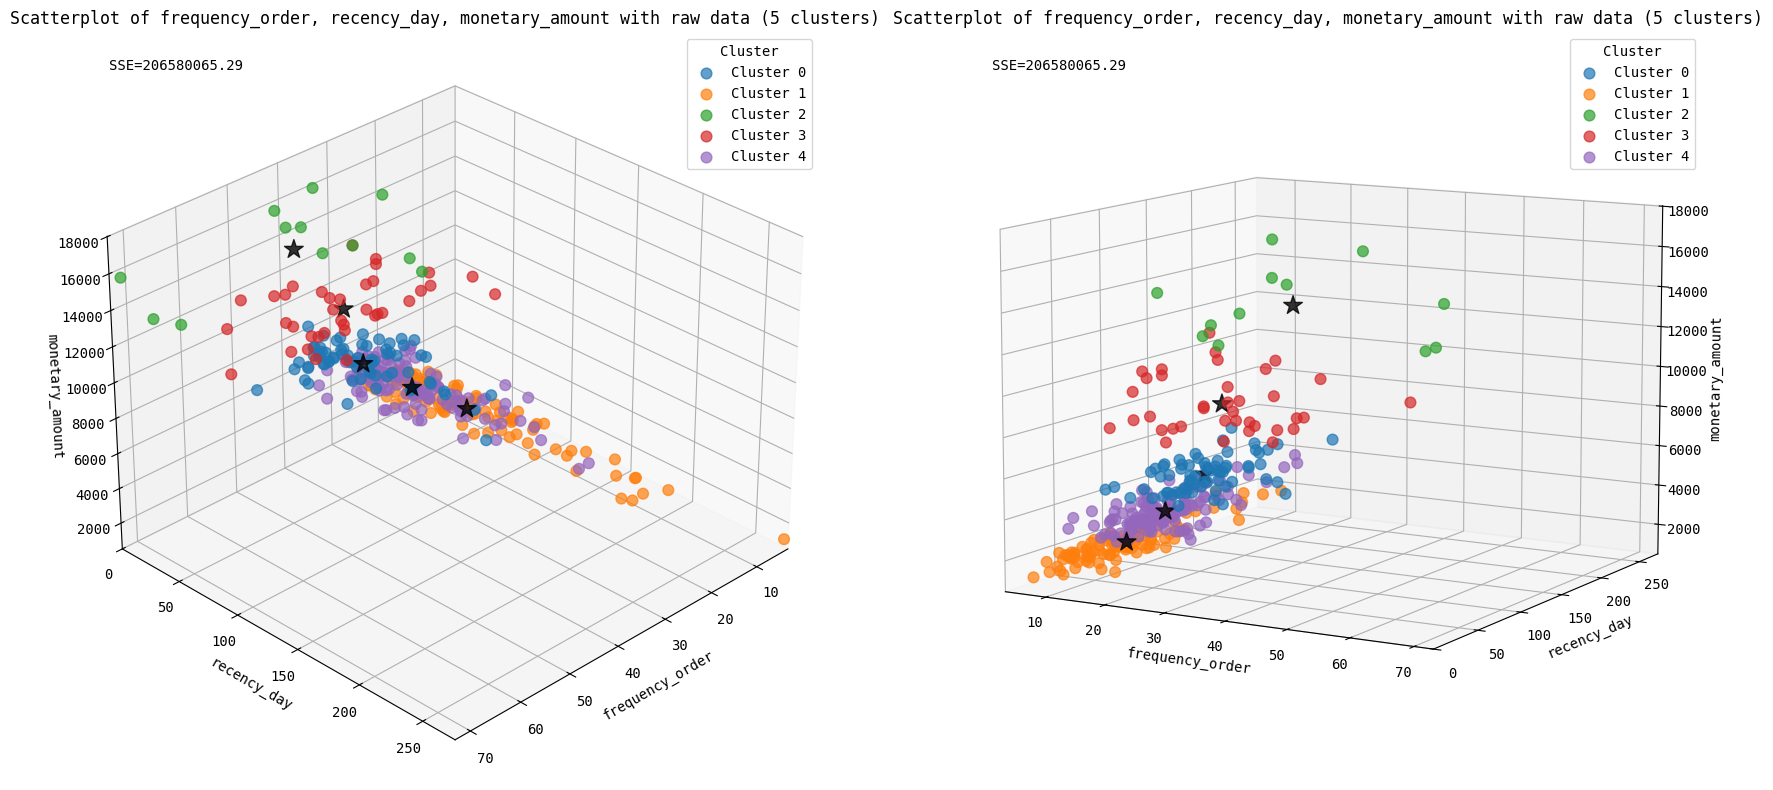

In [77]:
## Clusters with raw data

view_clust(df[["frequency_order","recency_day","monetary_amount"]],5,True)

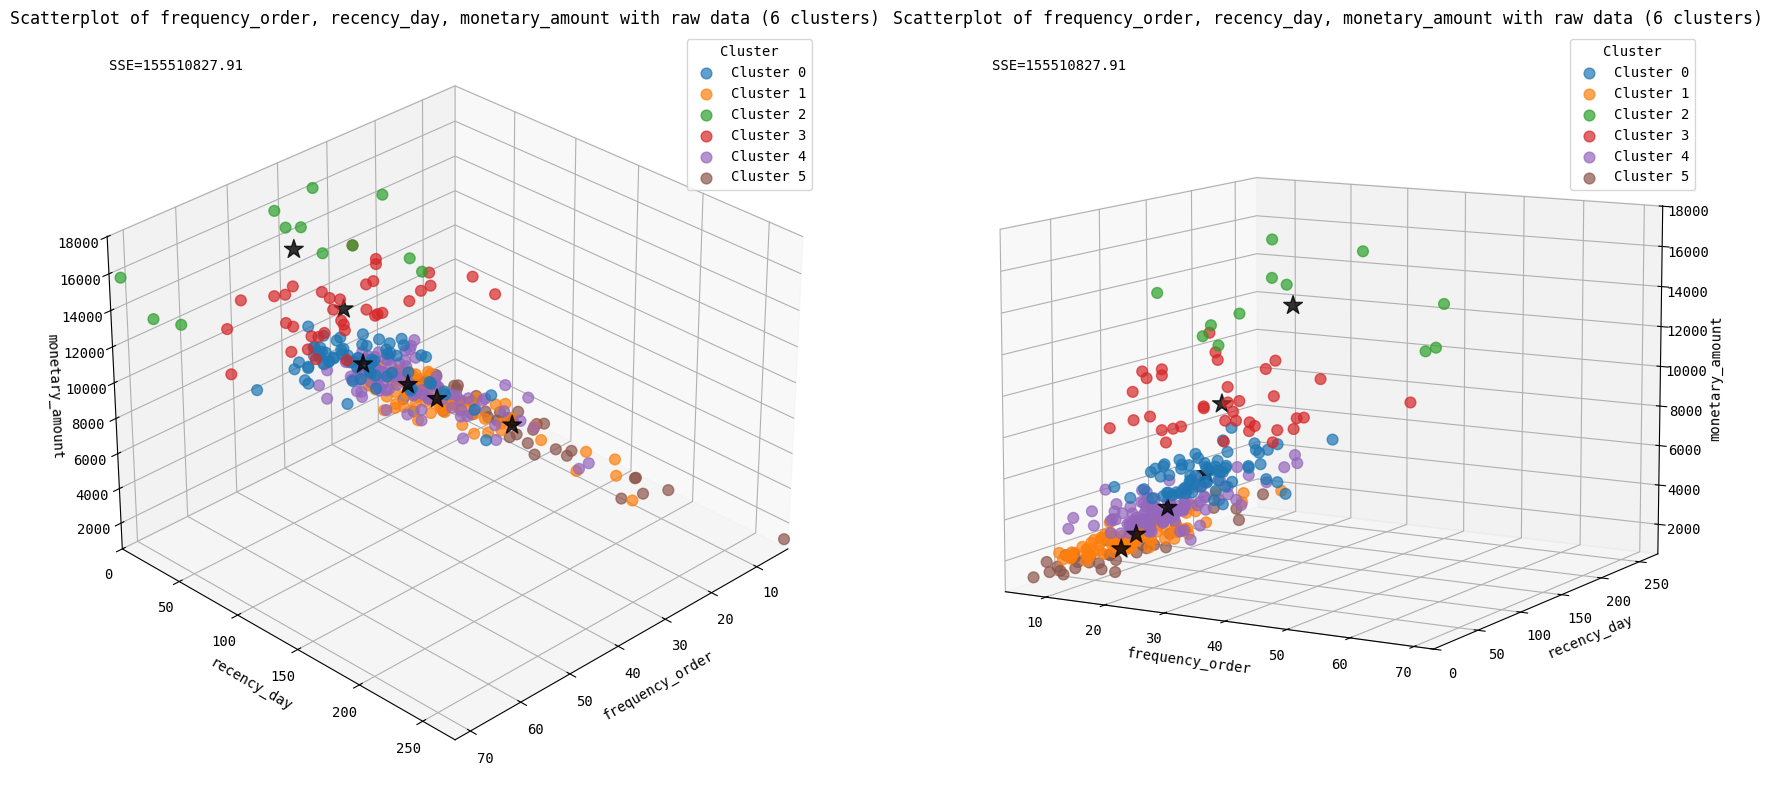

In [78]:
## Clusters with raw data

view_clust(df[["frequency_order","recency_day","monetary_amount"]],6,True)

#### **Final note on the number of clusters**

Based on the evaluation metrics, the 5-cluster solution appears to be the most appropriate.
The silhouette score decreases when moving from 5 to 6 clusters, indicating reduced cluster separation.
Additionally, the SSE (inertia) shows no substantial improvement when adding a sixth cluster, and the elbow point remains around k = 5.
Visual inspection of the cluster distribution also confirms that the segmentation is already well-defined with 5 clusters.

For these reasons, the 5-cluster solution will be adopted for the subsequent analysis.


### 2.2 Clustering with scaled/transformed data

In [79]:
# Apply transformation and standardize data

## Choose transformation and see differences between technique
### Defining function
def analyze_skewness(x):

    # Check if all values in the column are strictly positive
    # This is necessary for log and Box-Cox transformations
    if (df[x] > 0).all():
      fig, ax = plt.subplots(2, 2, figsize=(6,6))
      fig.suptitle(f"{x} skewness")

    #Raw data
      sbn.kdeplot(df[x], fill=True, ax=ax[0,0])
      ax[0,0].set_title("Raw data")

    #Log transformation
      sbn.kdeplot(np.log(df[x]), fill=True, ax=ax[0,1])
      ax[0,1].set_title("Log transformation")

    #Boxcox transformation
      sbn.kdeplot(stats.boxcox(df[x])[0], fill=True, ax=ax[1,0])
      ax[1,0].set_title("Boxcox transformation")

    #Yeo-Johnson
      sbn.kdeplot(stats.yeojohnson(df[x])[0], fill=True, ax=ax[1,1],warn_singular=False)
      ax[1,1].set_title("Yeo-Johnson transformation")

      ## Compare skewness values
      print('Log Transform : The skew coefficient of', df[x].skew().round(2), 'to', np.log(df[x]).skew().round(2))
      print('Box-Cox Transform : The skew coefficient of', df[x].skew().round(2), 'to', pd.Series(stats.boxcox(df[x])[0]).skew().round(2))
      print('Yeo-Johnson Transform : The skew coefficient of', df[x].skew().round(2), 'to', pd.Series(stats.yeojohnson(df[x])[0]).skew().round(2))

    else:
      # If not all values are positive, only Yeo-Johnson is generally applicable without issues
      fig, ax = plt.subplots(1, 2, figsize=(10,4))
      fig.suptitle(f"{x} skewness")

    #Raw data
      sbn.kdeplot(df[x], fill=True, ax=ax[0])
      ax[0].set_title("Raw data")
    #Yeo-Johnson
      sbn.kdeplot(stats.yeojohnson(df[x])[0], fill=True, ax=ax[1],warn_singular=False)
      ax[1].set_title("Yeo-Johnson transformation")

    ## Compare skewness values
      print('Yeo-Johnson Transform : The skew coefficient of', df[x].skew().round(2), 'to', pd.Series(stats.yeojohnson(df[x])[0]).skew().round(2))


    plt.tight_layout()
    plt.show()



Log Transform : The skew coefficient of 1.07 to -0.9
Box-Cox Transform : The skew coefficient of 1.07 to 0.05
Yeo-Johnson Transform : The skew coefficient of 1.07 to 0.05


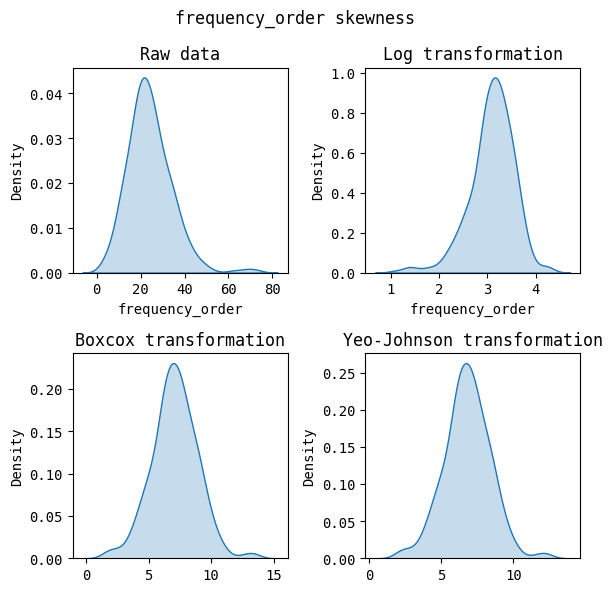

In [80]:
# Apply transformation and standardize data

## Choose transformation and see differences between technique

analyze_skewness(df.columns[1])

Yeo-Johnson Transform : The skew coefficient of 1.77 to -0.06


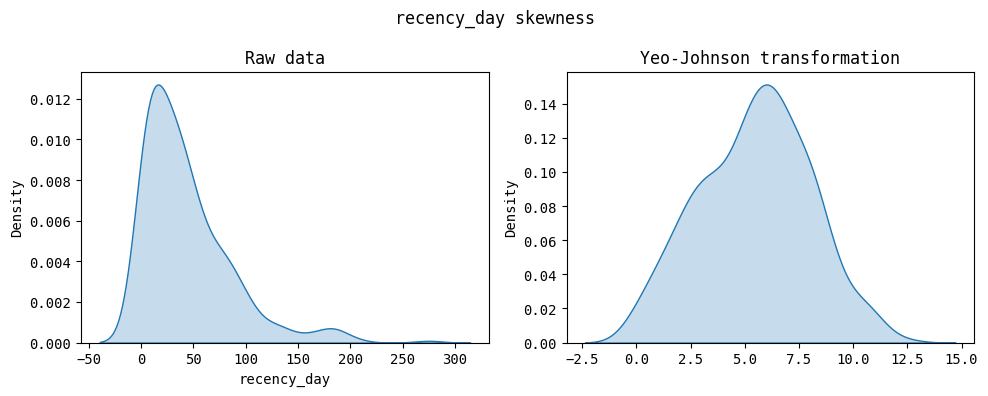

In [81]:
# Apply transformation and standardize data

## Choose transformation and see differences between technique

analyze_skewness(df.columns[2])

Log Transform : The skew coefficient of 1.44 to -0.38
Box-Cox Transform : The skew coefficient of 1.44 to 0.01
Yeo-Johnson Transform : The skew coefficient of 1.44 to 0.01


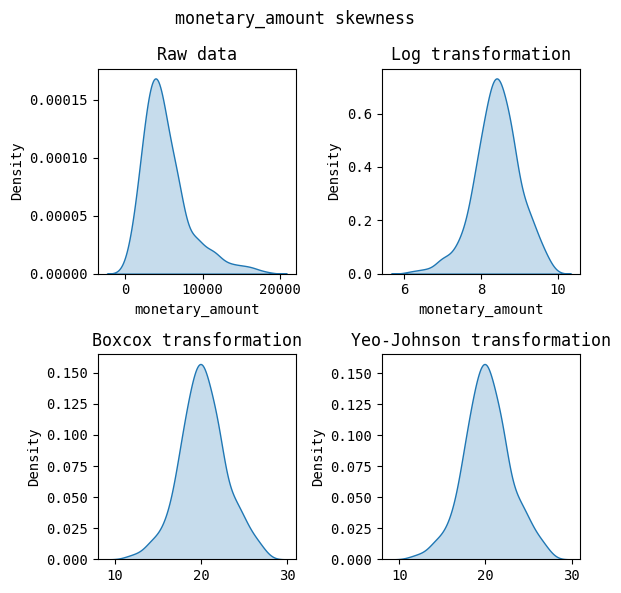

In [82]:
# Apply transformation and standardize data

## Choose transformation and see differences between technique

analyze_skewness(df.columns[3])

#### **Note on transformation techniques**

The comparison of the transformation methods shows that the Yeo–Johnson transformation is best technique for reducing skewness across all variables.
This is also the only method that can be applied to the recency feature, since it contains zero values (log and Box-Cox require positive data).

Moreover, Yeo–Johnson improve symmetry without removing or discarding observations.
However, this rescaling may affect the relative importance of very large values, which can influence distance-based clustering.

* For this reason, clustering will also be performed using transformed data, in order to compare the results with those obtained from raw data and assess whether the transformation is beneficial for RFM segmentation

#### 2.1.1 Transforming data

In [83]:
## Transform data with Yeo-Johnson technique
df_yj=pd.DataFrame()
df_yj["Frequency"]=stats.yeojohnson(df[df.columns[1]])[0]
df_yj["Recency"]=stats.yeojohnson(df[df.columns[2]])[0]
df_yj["Monetary"]=stats.yeojohnson(df[df.columns[3]])[0]

In [84]:
print(df[df.columns[[1,2,3]]].head(10))
print(df_yj.head(10))

   frequency_order  recency_day  monetary_amount
0               10            4          1649.21
1               19           17          5893.28
2               25           52          4645.74
3               35          151          6827.34
4               16           30          3342.64
5               24           16          4727.59
6               22            1          3605.78
7               18           87          2631.90
8               18           45          3824.66
9               38            2          6127.84
   Frequency    Recency   Monetary
0   4.193454   1.983566  15.754303
1   6.103118   4.247823  21.327541
2   7.109043   6.812699  20.185349
3   8.525057  10.083798  22.059358
4   5.534547   5.452054  18.684610
5   6.951366   4.130500  20.267529
6   6.624850   0.757173  19.022084
7   5.919364   8.279171  17.650220
8   5.919364   6.435318  19.287797
9   8.904753   1.265222  21.519762


In [85]:
# Standardisation

## Initialize StandardScaler()
strd=StandardScaler()

## Fit
strd.fit(df_yj)

## Transform
df_std=strd.transform(df_yj)

## Std dataframe
df_std=pd.DataFrame(df_std,columns=["Frequency","Recency","Monetary"])

In [86]:
df_std

,Frequency,Recency,Monetary
0,-1.617780,-1.369594,-1.628264
1,-0.429345,-0.478429,0.435931
2,0.196668,0.531053,0.012890
3,1.077891,1.818490,0.706978
4,-0.783182,-0.004469,-0.542948
...,...,...,...
345,-1.463203,0.964175,-1.219700
346,3.528417,-0.855343,2.443859
347,-0.318207,1.066357,-0.156088
348,1.157862,0.137663,1.402061


#### 2.1.2 How many clusters do we need?

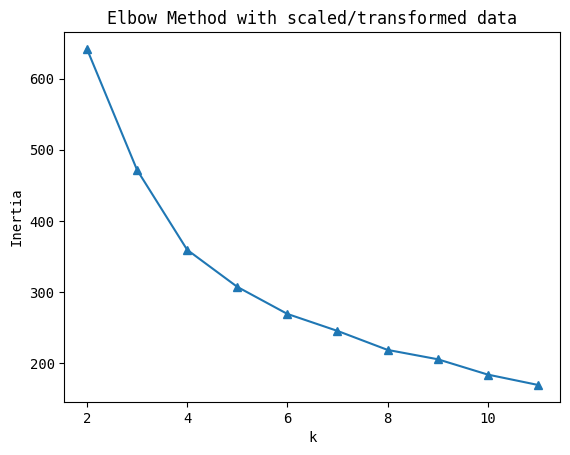


INERTIA (SSE) VALUES:
2 : 1.2123053474589696
3 : 1.040040806990098
4 : 0.9171435874624865
5 : 0.8452023100103887
6 : 0.7964998383780897
7 : 0.7625857861869485
8 : 0.7216502815068367
9 : 0.6899435072589925
10 : 0.6552704420278144
11 : 0.6310368411117945




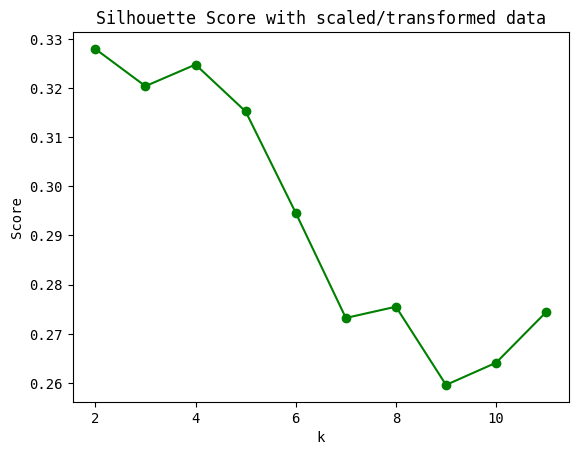

In [87]:
how_many_clusters(df_std,False)

#### 2.1.3 Show clusters

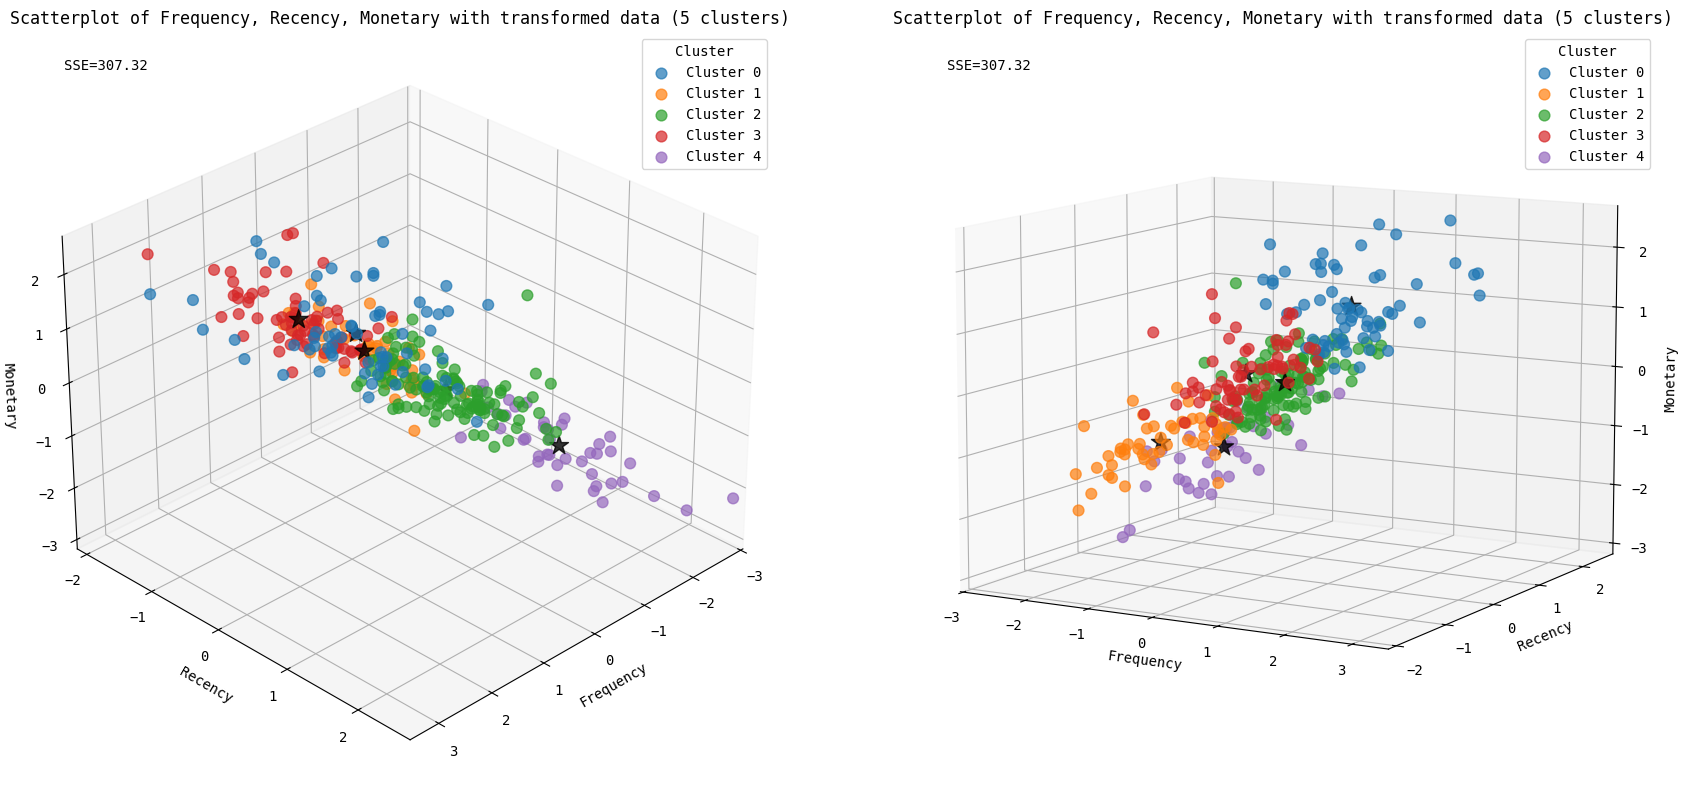

In [88]:
## Clustering with transformed data and 5 clusters
view_clust(df_std, 5, False)


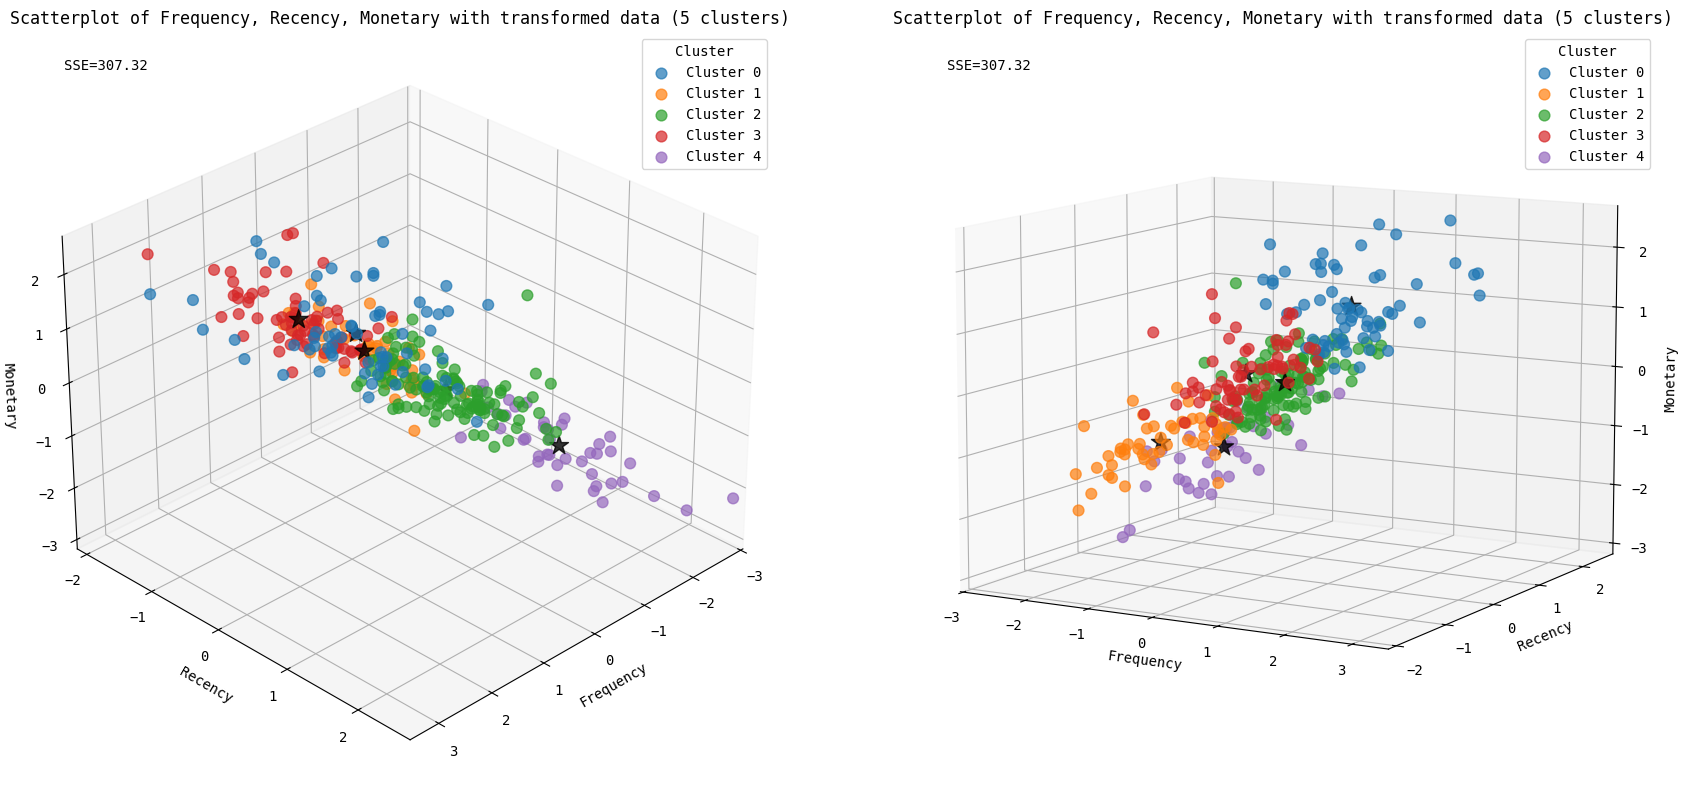

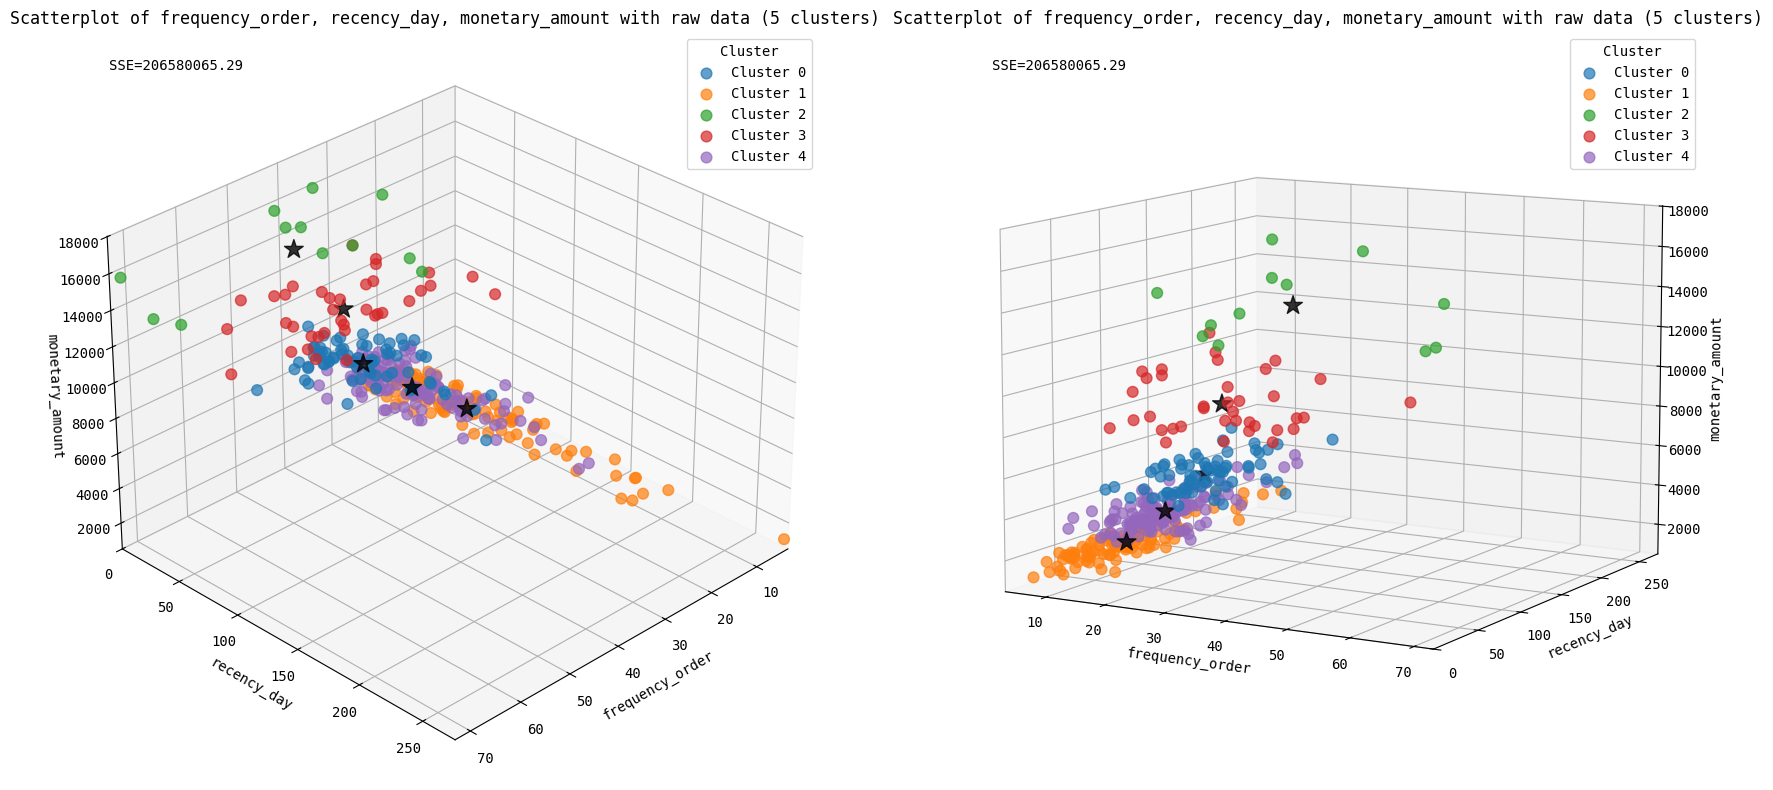

In [89]:
# Create plot to compare two clustering
# fig,ax=subplots(2,2,figsize=(14,8))
## Clustering with transformed data and 5 clusters
view_clust(df_std, 5, False)

## Clustering with raw data
view_clust(df[["frequency_order","recency_day","monetary_amount"]],5,True)

#### **Note on clustering with raw and transformed data**

Looking at the two scatter plots (raw vs. transformed data), we can observe the following:

1. The transformed data compress extreme values, especially for the Monetary variable. As a result, the scatter plot of the transformed dataset appears more centered and uniformly distributed, while the raw dataset shows elongated shapes driven by the wide range of the Monetary variable.

2. Comparing the SSE values reveals a clear difference in clustering quality.
With transformed data, the SSE is around 306, indicating compact and well-defined clusters.
With raw data, the SSE is around 206,580,065, which reflects the fact that distances are dominated by the Monetary variable (max ≈ 18,000), whose scale is much larger than the other variables (max ≈ 70 and 250).
This large difference in scale creates the illusion of more visually separated centroids in the raw scatter plot, even though mathematically the clustering is far less effective.

The transformed dataset provides a more appropriate basis for RFM segmentation

## 3. RFM Segmentation

### 3.1 How is each cluster represented by RFM features?

In [90]:
## Fit model
mod=KMeans(n_clusters=5,init="k-means++",random_state=SEED).fit(df_std)
df["Cluster"]=mod.predict(df_std)

In [91]:
## Create dataframe with cluster for each customer_id
df_rfm=pd.DataFrame(df_std)
df_rfm.insert(0,"ID",df['customer_id'])
df_rfm["Cluster"]=mod.labels_

In [92]:
df_rfm

,ID,Frequency,Recency,Monetary,Cluster
0,1,-1.617780,-1.369594,-1.628264,1
1,2,-0.429345,-0.478429,0.435931,3
2,3,0.196668,0.531053,0.012890,2
3,4,1.077891,1.818490,0.706978,0
4,5,-0.783182,-0.004469,-0.542948,2
...,...,...,...,...,...
345,346,-1.463203,0.964175,-1.219700,4
346,347,3.528417,-0.855343,2.443859,0
347,348,-0.318207,1.066357,-0.156088,2
348,349,1.157862,0.137663,1.402061,0


In [93]:
## Get long form of df_frm in order to use snake plot

df_melt=pd.melt(frame=df_rfm.reset_index(),
                id_vars=["ID","Cluster"],
                value_vars=["Frequency","Recency","Monetary"],
                var_name="RFM",
                value_name="Value")

In [94]:
df_melt

,ID,Cluster,RFM,Value
0,1,1,Frequency,-1.617780
1,2,3,Frequency,-0.429345
2,3,2,Frequency,0.196668
3,4,0,Frequency,1.077891
4,5,2,Frequency,-0.783182
...,...,...,...,...
1045,346,4,Monetary,-1.219700
1046,347,0,Monetary,2.443859
1047,348,2,Monetary,-0.156088
1048,349,0,Monetary,1.402061


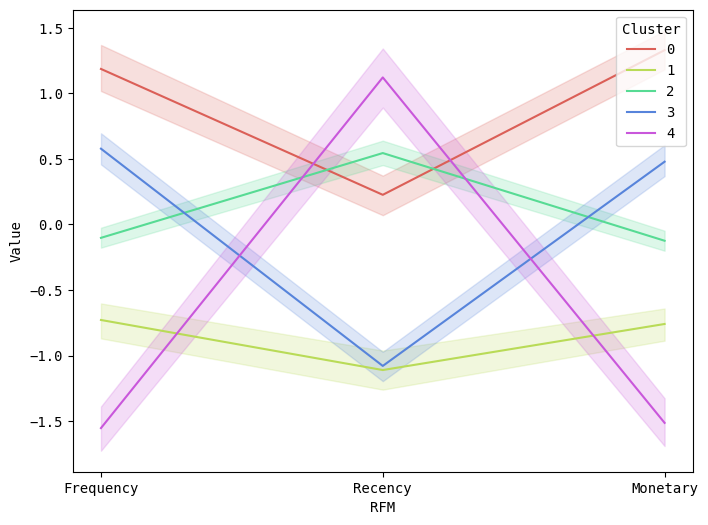

In [95]:
## Create snake plot
plt.figure(figsize=(8,6))
sbn.lineplot(data=df_melt,x="RFM",y="Value",hue="Cluster",palette=palette)
plt.legend(title="Cluster",loc="upper right")
plt.show()

#### **Note on the snake chart**

Although the snake chart is not fully interpretable due to data transformation, it is still useful to compare the overall RFM patterns across clusters.
Below is an interpretation based on relative differences in Frequency, Recency, and Monetary values.

- Cluster 0  (High-value lapsed customers)

  - High purchase frequency
  - High monetary value
  - Not recent purchases (high standardized recency)

  These customers were highly valuable in the past but have lapsed.
  They are strong candidates for re-engagement and win-back campaigns (e.g., personalized promotions, reminders, product recommendations).

---

- Cluster 1 (Recent low-value customers)

  - Low purchase frequency
  - Low monetary value
  - Recent purchases

  These customers have purchased recently but with low spending and low engagement.
  They may be new or occasional buyers, ideal for activation strategies, such as  small incentives to boost repeat purchases.

---

- Cluster 2 (Mid-value lapsed customers)

  - Medium purchase frequency
  - Medium monetary value
  - Not recent purchases
  
  These customers used to buy occasionally with moderate spending but have not returned for some time.
  They could be targeted with category-specific discounts or personalized product reminders to bring them back.
---

- Cluster 3  (High-value recent customers)

  - High purchase frequency
  - High monetary value
  - Recent purchases

  These are the best customers: active, loyal, and high-spending.
  They are ideal for loyalty programs, VIP treatment, or exclusive offers.

---

- Cluster 4 (Low-value inactive customers)

  - Low purchase frequency
  - Low monetary value
  - Not recent purchases

  These customers show very low engagement and have not purchased recently.

### 3.2 What is the percentage of customers for each cluster?

In [96]:
## Create dataframe with percent for each cluster
df_perc=df_melt.groupby("Cluster").agg(Size=("ID","count"))
df_perc.insert(1,"Percent", ((df_perc["Size"]/df_perc["Size"].sum())*100).round(1))

In [97]:
## Reset index in order to get correct columns and index
df_perc=df_perc.reset_index()

In [98]:
df_perc

,Cluster,Size,Percent
0,0,195,18.6
1,1,153,14.6
2,2,369,35.1
3,3,204,19.4
4,4,129,12.3


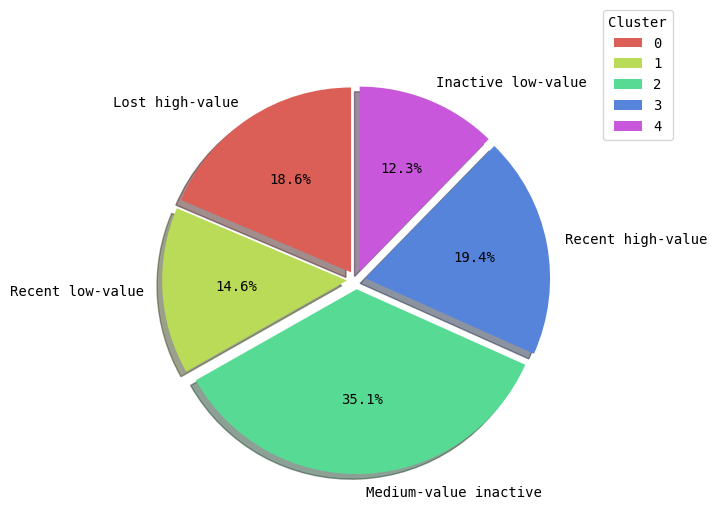

In [99]:
### Rename columns
df.columns=["ID","Frequency","Recency","Monetary","Cluster"]

### Add Cluster label column
clust_lab = {0: "Lost high-value",
                  1: "Recent low-value",
                  2: "Medium-value inactive",
                  3: "Recent high-value",
                  4: "Inactive low-value"
}

df["Cluster_Label"]=df["Cluster"].map(clust_lab)
df_perc["Cluster_Label"]=df_perc["Cluster"].map(clust_lab)

df["Monetary"]=df["Monetary"].round(2)


## Create pie chart
explode = (0.05, 0.05, 0.05, 0.05, 0.05)
fig, ax = plt.subplots(figsize=(8,6))
ax.pie(df_perc["Percent"], explode=explode,labels=df_perc['Cluster_Label'],autopct='%1.1f%%',
       shadow=True, startangle=90,colors=palette)
ax.legend(title="Cluster",labels=df_perc["Cluster"],loc="upper right",bbox_to_anchor=(1.2,1.1))
plt.show()

##### **Note on the pie chart**

- 35% of customers belong to Cluster 2 (medium-value customers who have stopped buying). It is necessary to assess how to bring these customers back, as they represent an important part of the company's customer base.
- Approximately 19% of customers belong to Cluster 3 (recent high-value customers). These customers are very important because they represent the solid foundation of the company's revenue.
- 18% of customers belong to Cluster 0 (lost high-value customers). This cluster also contains potentially high-value customers, but a strategy must be found to win them back.
- 14% of customers belong to cluster 1 (recent low-value customers). Although they represent a small portion of the total, these customers should be encouraged to purchase because they could be potentially profitable.
- 12% of customers belong to cluster 4 (inactive low-value customers). This is good news because they represent a small portion of customers, but it is important to understand why they are inactive. Further analysis is required.

### 3.3 How relevant is each RFM feature for each cluster?

In [100]:
## Create heatmap with relative percent that compared cluster and population values of RFM

## Get mean for each clusters by RFM features
cluster_avg=df.groupby("Cluster").agg({
    "Frequency": "mean",
    "Recency": "mean",
    "Monetary": "mean"}).round(2).reset_index()

## Get mean of RFM features by original sample in order to compare with cluster_avg
sample_avg=df[["Frequency","Recency","Monetary"]].mean()

In [101]:
cluster_avg

,Cluster,Frequency,Recency,Monetary
0,0,37.06,44.18,9806.67
1,1,16.71,8.59,3014.72
2,2,22.24,58.20,4402.65
3,3,29.40,8.54,6225.69
4,4,10.77,99.28,1910.87


In [102]:
sample_avg

,0
Frequency,24.168571
Recency,43.768571
Monetary,5252.066229


In [103]:
## Calculate the ratio between the average RFM in the clusters and the average RFM in the original sample
relative_rfm=((cluster_avg/sample_avg)-1).drop("Cluster",axis=1)
relative_rfm.index.name="Cluster"
relative_rfm=relative_rfm.rename(columns={"frequency_order":"Frequency","recency_day":"Recency","monetary_amount":"Monetary"})

## Re-order columns
relative_rfm = relative_rfm[["Frequency","Recency","Monetary", ]]


In [104]:
relative_rfm

,Frequency,Recency,Monetary
Cluster,,,
0,0.533396,0.009400,0.867202
1,-0.308606,-0.803740,-0.425994
2,-0.079797,0.329721,-0.161730
3,0.216456,-0.804883,0.185379
4,-0.554380,1.268294,-0.636168


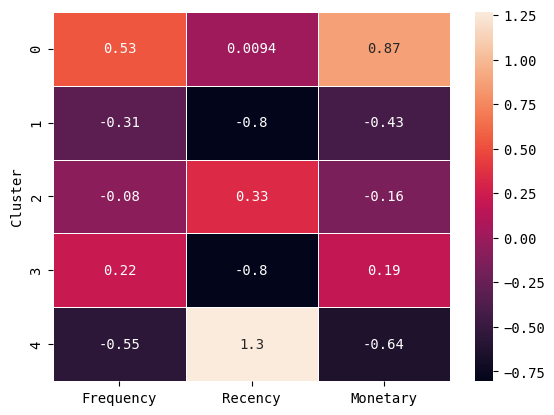

In [105]:
## Heatmap of ratio RFM for each clusters
sbn.heatmap(data=relative_rfm,annot=True,linewidths=0.5)
plt.show()

#### **Note on heatmap**

The heatmap shows the relative importance of each RFM feature within each cluster.
Each value represents the ratio:

$$
RI_{c,f} = \frac{\bar{x}_{c,f}}{\bar{x}_{f}} - 1
$$

$
\begin{aligned}
c \;&=\; \text{cluster} \\
f \;&=\; \text{feature RFM (Frequency, Recency, Monetary)} \\
\bar{x}_{c,f} \;&=\; \text{media della feature } f \text{ nel cluster } c \\
\bar{x}_{f} \;&=\; \text{media della feature } f \text{ nell'intero campione}
\end{aligned}\\
$


This indicates how much each cluster differs from the overall customer base:

- Values > 0 → the cluster is above the population average on that RFM dimension

- Values < 0 → the cluster is below the population average

This visualization allows us to quickly identify which clusters have higher or lower Recency, Frequency, and Monetary values compared to the entire dataset, making the interpretation more intuitive than using transformed variables alone.

The result with the original data (without any transformation) confirms and shows the same cluster behaviour pattern observed previously in the snake graph.

## 4. Conclusion

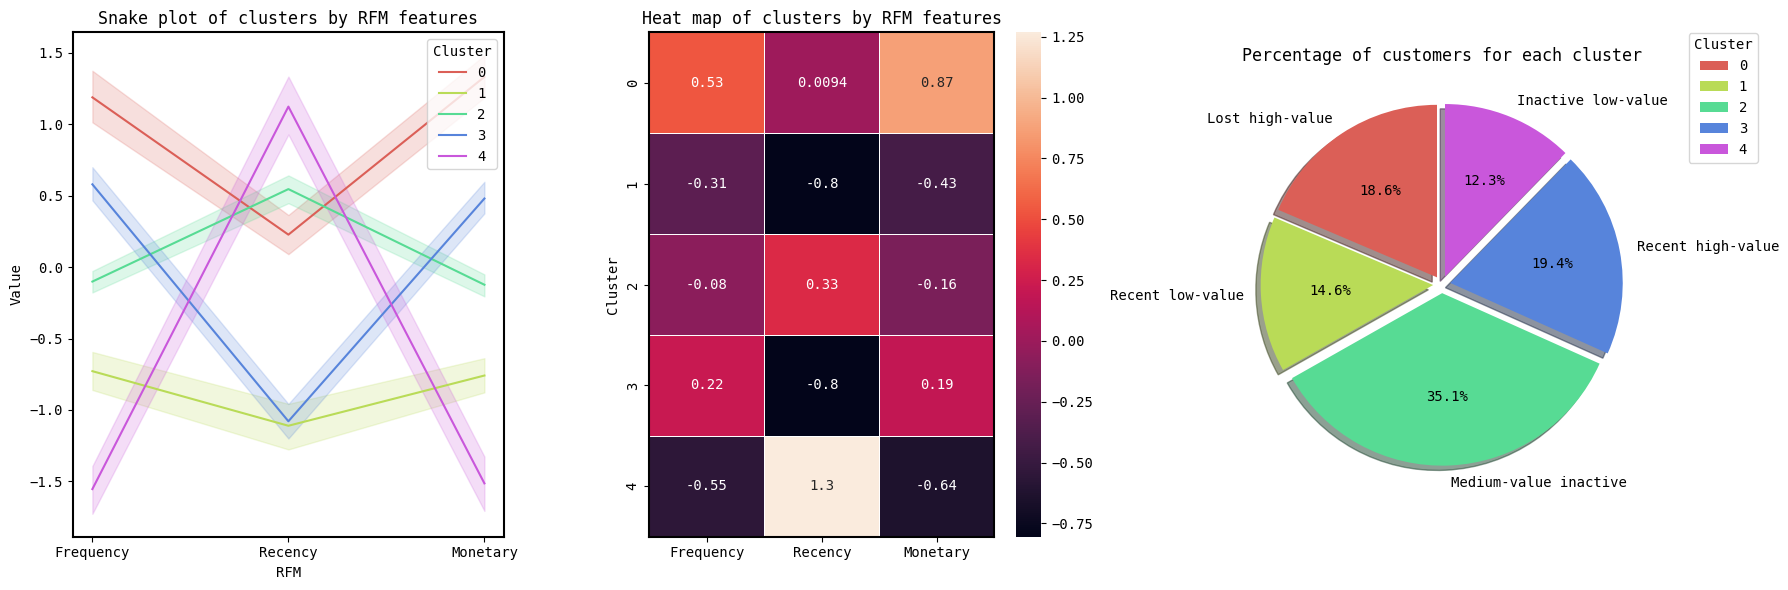

In [106]:
## Compare snake plot (transformed data) and heatmap (original data)
fig,(ax,ax2,ax3)=plt.subplots(1,3,figsize=(18,6))

## Function for border
def add_border(axis, lw=1.5):
    for line in axis.spines.values():
        line.set_visible(True)
        line.set_linewidth(lw)


## Create snake plot
sbn.lineplot(data=df_melt,x="RFM",y="Value",hue="Cluster",palette=palette,ax=ax)
ax.legend(title="Cluster",loc="upper right")
ax.set_title("Snake plot of clusters by RFM features")
add_border(ax)

## Heatmap of ratio RFM for each clusters
sbn.heatmap(data=relative_rfm,annot=True,linewidths=0.5,ax=ax2)
ax2.set_title("Heat map of clusters by RFM features")
add_border(ax2)

## Create pie chart
explode = (0.05, 0.05, 0.05, 0.05, 0.05)
ax3.pie(df_perc["Percent"], explode=explode,labels=df_perc['Cluster_Label'],autopct='%1.1f%%',
       shadow=True, startangle=90,colors=palette)
ax3.legend(title="Cluster",labels=df_perc["Cluster"],loc="upper right",bbox_to_anchor=(1.25,1.1))
ax3.set_title("Percentage of customers for each cluster")


plt.tight_layout()
plt.show()

#### **Final Insights**

The goal of this analysis was to segment customers using the RFM model in order to identify different purchasing behaviours and derive actionable business strategies.

The segmentation produced 5 clusters with distinct behaviors:

- **Cluster 0**: high-value but lapsed customers, offering strong reactivation potential.
- **Cluster 1**: recent but low-value customers with potential to grow.
- **Cluster 2**: medium-value but inactive, the largest group and a priority for re-engagement.
- **Cluster 3**: recent and high-value customers, representing the core revenue base.
- **Cluster 4**: inactive low-value users with limited strategic relevance.

Both the snake plot (based on transformed variables) and the heatmap (based on original values) consistently highlighted the same behavioural patterns across clusters, confirming the robustness of the segmentation.

Based on these insights, the recommended actions are:


- Launch reactivation incentives for Cluster 0 and Cluster 2, as they represent the highest potential uplift.
- Encourage Cluster 1 to increase purchase frequency through low-value targeted promotions.
- Focus retention campaigns and personalized offers on Cluster 3 to maintain high-value customers.
- Limit investment on Cluster 4, which shows minimal strategic relevance.

## Export Dataset

In [107]:
## Final dataset
df

,ID,Frequency,Recency,Monetary,Cluster,Cluster_Label
0,1,10,4,1649.21,1,Recent low-value
1,2,19,17,5893.28,3,Recent high-value
2,3,25,52,4645.74,2,Medium-value inactive
3,4,35,151,6827.34,0,Lost high-value
4,5,16,30,3342.64,2,Medium-value inactive
...,...,...,...,...,...,...
345,346,11,77,2175.17,4,Inactive low-value
346,347,73,10,16115.55,0,Lost high-value
347,348,20,84,4212.10,2,Medium-value inactive
348,349,36,35,9786.69,0,Lost high-value


In [108]:
## Table with percentage for each cluster
df_perc

,Cluster,Size,Percent,Cluster_Label
0,0,195,18.6,Lost high-value
1,1,153,14.6,Recent low-value
2,2,369,35.1,Medium-value inactive
3,3,204,19.4,Recent high-value
4,4,129,12.3,Inactive low-value


In [109]:
## Create interactive table

### Dataset with clusters
render(df,to_file="df.html",buttons=['copy','csv'])


## Table with size and percentage of clusters
render(df_perc,to_file="df_perc.html",buttons=['copy','csv'])

Successfully created DataTable at: df.html
Failed to open file 'df.html': Couldn't find a suitable web browser!

Set the BROWSER environment variable to your desired browser.

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'df.html'

Successfully created DataTable at: df_perc.html
Failed to open file 'df_perc.html': Couldn't find a suitable web browser!

Set the BROWSER environment variable to your desired browser.

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'df_perc.html'



'df_perc.html'